# Dataset Downloading & Unzipping

In [19]:
import os
!pip install kaggle -q
os.environ['KAGGLE_USERNAME'] = "saikowndinya"
os.environ['KAGGLE_KEY'] = "de0e780aef58aa3ea09e05bc35e9c9da"
!kaggle datasets download "oral-cancer-lips-and-tongue-images"

403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/datasets/metadata/saikowndinya/oral-cancer-lips-and-tongue-images


In [18]:
!unzip -q new-oral-cancer.zip

unzip:  cannot find or open new-oral-cancer.zip, new-oral-cancer.zip.zip or new-oral-cancer.zip.ZIP.


# Importing Libraries

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,Dense,Dropout,BatchNormalization,Flatten,MaxPool2D,MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50,DenseNet121,EfficientNetB2
from tensorflow.keras import layers


# Dataset Loading & Spliting

In [ ]:
# Load data
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['cancer', 'non cancer']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            image = load_img(image_path, target_size=(260, 260))  # Adjust target size as needed
            image_array = img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

folder_path = "/content/OC"
images, labels = load_data(folder_path)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)


# Model Training

In [ ]:
# Define and compile the model
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(260, 260, 3))

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Add your own classification layers on top of the base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(1, activation='sigmoid')(x)

model_EfficientNetB2 = Model(inputs=base_model.input, outputs=predictions)

model_EfficientNetB2.compile(loss='binary_crossentropy',metrics=['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
checkpoint_filepath = 'Best Model.keras'
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',  # Save the model based on validation accuracy
    save_best_only=True,     # Only save the best model
    mode='max',              # Save the model when the monitored quantity is maximized
    verbose=1
)

In [ ]:
# Train the model
history = model_EfficientNetB2.fit(
    x= X_train,
    y= y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr,checkpoint]
)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.7743 - loss: 0.4289 - precision_5: 0.7466 - recall_5: 0.8277
Epoch 1: val_accuracy improved from -inf to 0.90426, saving model to Best Model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7772 - loss: 0.4258 - precision_5: 0.7497 - recall_5: 0.8292 - val_accuracy: 0.9043 - val_loss: 0.2303 - val_precision_5: 0.9048 - val_recall_5: 0.8837 - learning_rate: 0.0010
Epoch 2/50
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9062 - loss: 0.2208 - precision_5: 0.8933 - recall_5: 0.9313
Epoch 2: val_accuracy improved from 0.90426 to 0.93085, saving model to Best Model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 138ms/step - accuracy: 0.9067 - loss: 0.2197 - precision_5: 0.8939 - recall_5: 0.9306 - val_accuracy: 0.9309 - val_loss: 0.2021 - val_precision_5: 0.9740 - val_recall_5: 0.8721 - learning_rate: 0.0010
Epoch 3/50
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9576 - loss: 0.1171 - precision_5: 0.9712 - re

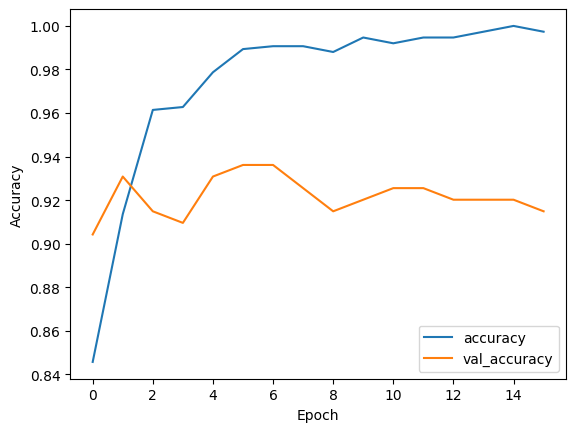

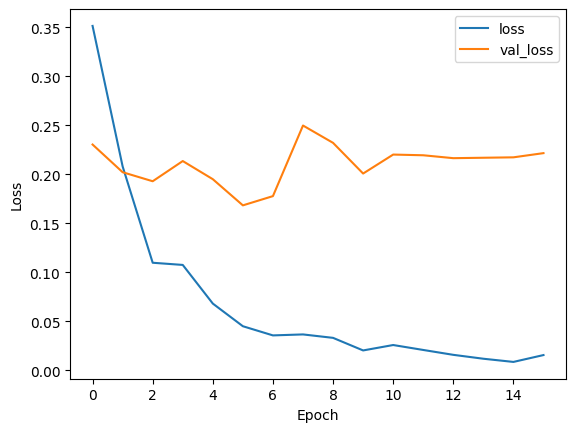

In [ ]:
# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Get Final Training and Validation Accuracy
final_train_acc = history.history['accuracy'][-1]  # Last epoch training accuracy
final_val_acc = history.history['val_accuracy'][-1]  # Last epoch validation accuracy

print(f"Last Training Accuracy: {final_train_acc * 100:.2f}%")
print(f"Last Testing Accuracy: {final_val_acc * 100:.2f}%")


Last Training Accuracy: 99.73%
Last Testing Accuracy: 91.49%


In [ ]:
model_EfficientNetB2.save("Model.keras")

# Evaluation

In [ ]:
!md5sum Model.keras

18b7ac361949cffcf20a8b796045db22  Model.keras


In [ ]:
model_EfficientNetB2 = tf.keras.models.load_model("Model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Raw Prediction Score: 0.8069


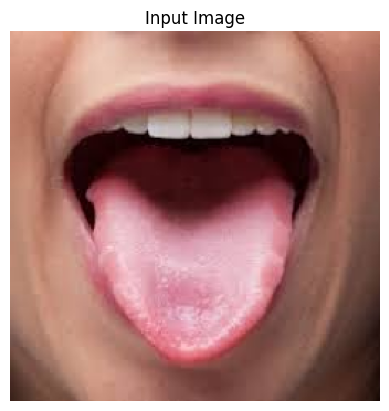

Prediction: No Oral Cancer Detected (Confidence: 80.69%)


In [32]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def predict_image(image_path, model):
    # Load and preprocess the image
    image = load_img(image_path, target_size=(260, 260))
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    # image_array = image_array / 255.0  # Uncomment if normalization was used during training

    # Make a prediction
    prediction = model.predict(image_array)[0][0]  # Get the probability score
    print(f"Raw Prediction Score: {prediction:.4f}")

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Interpret the result with confidence score
    if prediction <= 0.5:
        print(f"Prediction: Oral Cancer Detected (Confidence: {100 - prediction * 100:.2f}%)")
    else:
        print(f"Prediction: No Oral Cancer Detected (Confidence: {prediction * 100:.2f}%)")

# Example usage:
image_path = "/content/OralCancer/non-cancer/images.jpeg"  # Change path for testing
predict_image(image_path, model_EfficientNetB2)


In [ ]:
model_EfficientNetB2.evaluate(X_test,y_test,return_dict=True)

6/6 ━━━━━━━━━━━━━━━━━━━━ 284s 45s/step - accuracy: 0.9868 - loss: 0.0466 - precision_5: 0.9947 - recall_5: 0.9766


{'accuracy': 0.9840425252914429,
 'loss': 0.049581121653318405,
 'precision_5': 0.9882352948188782,
 'recall_5': 0.9767441749572754}